# A/B Testing - Customer Retention

In [1]:
#import all models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
#read the dataset
df = pd.read_csv("data/cookie_cats.csv")

In [3]:
#print dataset
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.shape

(90189, 5)

## Exploratory Analysis

In [5]:
#Number of unique users
df['userid'].nunique()

90189

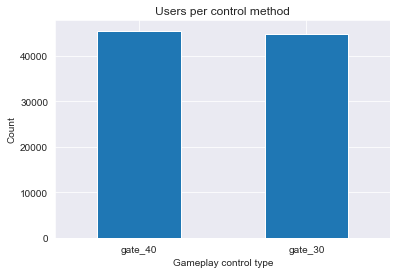

In [12]:
df['version'].value_counts().plot(kind="bar")
plt.xlabel("Gameplay control type")
plt.ylabel("Count")
plt.title("Users per control method")
plt.xticks(rotation=0)
plt.savefig("images/User_per_group.png")

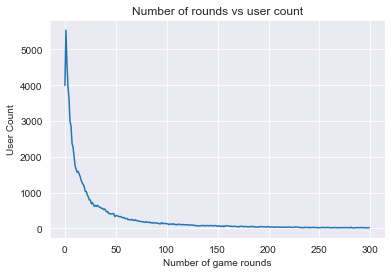

In [7]:
df.groupby('sum_gamerounds').count()['userid'].iloc[:300,].plot()
plt.xlabel("Number of game rounds")
plt.ylabel("User Count")
plt.title("Number of rounds vs user count")
plt.savefig("images/games_vs_users.png")

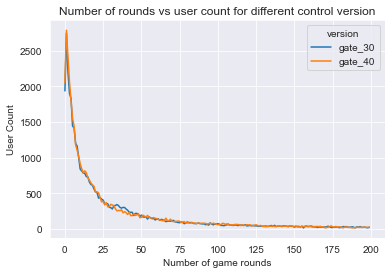

In [8]:
df.groupby(['version','sum_gamerounds'])['userid'].count().unstack('version').head(200).plot()
plt.xlabel("Number of game rounds")
plt.ylabel("User Count")
plt.title("Number of rounds vs user count for different control version")
plt.savefig("images/games_vs_users_control.png")

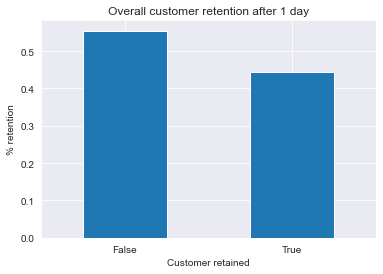

In [13]:
df['retention_1'].value_counts(normalize=True).plot(kind="bar")
plt.xlabel("Customer retained")
plt.ylabel("% retention")
plt.title("Overall customer retention after 1 day")
plt.xticks(rotation=0)
plt.savefig("images/1_day_retention.png")

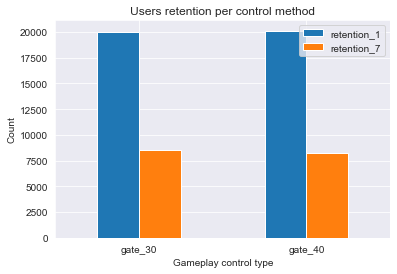

In [14]:
df.groupby('version').sum()[['retention_1','retention_7']].plot(kind="bar")
plt.xlabel("Gameplay control type")
plt.ylabel("Count")
plt.title("Users retention per control method")
plt.xticks(rotation=0)
plt.savefig("images/User_retention_control_methods.png")

In [83]:
print(df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count())
print("")
print(df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count())

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

version
gate_30    0.190201
gate_40    0.182000
dtype: float64


From the plot above it is hard to tell if one gameplay control is better than the other. From the % of customers retained it looks like the 30 games is perfoming better. 

However there is not sufficient evidence or data to support this. We can create a bootstrapped distribution of the mean % of customers retained by each method

## Bootstrapping

In [85]:
# Bootstrapping

boot_1d = []
boot_7d = []

for i in range(1000):
    boot_mean_1 = df.sample(frac=1,replace=True).groupby('version').mean()['retention_1']
    boot_mean_7 = df.sample(frac=1,replace=True).groupby('version').mean()['retention_1']
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

In [86]:
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

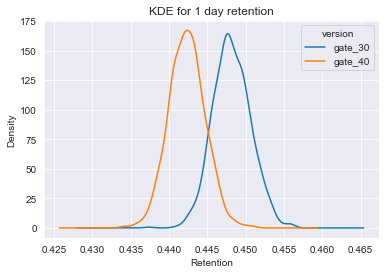

In [87]:
boot_1d.plot(kind='kde')
plt.xlabel("Retention")
plt.title("KDE for 1 day retention")
plt.savefig("images/mean_retention_distribution.png")

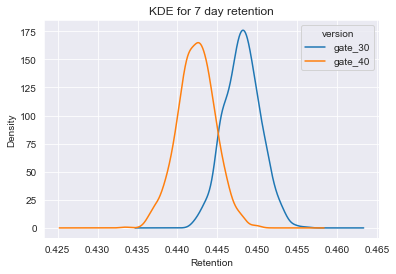

In [88]:
boot_7d.plot(kind='kde')
plt.xlabel("Retention")
plt.title("KDE for 7 day retention")
plt.savefig("images/mean_retention_distribution7.png")

## Porbability Distribution and T-test

In [89]:
#We can also draw the difference between the two probability curves as below:

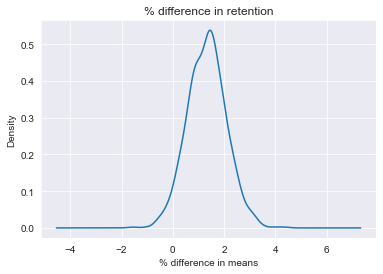

In [90]:
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100


# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")
plt.title("% difference in retention")
plt.savefig("images/mean_retention_difference.png")

Text(0.5, 0, '% difference in means')

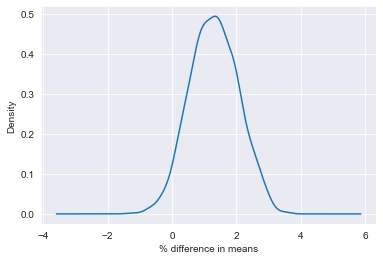

In [91]:
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

H0 - The two control methods have the same mean


H1 - The two control methods do not have the same mean

Conduction t test on the 1 day retainment and 7 day retainment.

In [92]:
from scipy import stats
#Perform t-test on bootstrapped data
tc, pc = stats.ttest_ind(boot_1d['gate_30'], boot_1d['gate_40'])
print ("t-test: t = %g  p = %g" % (tc, pc))

t-test: t = 54.4479  p = 0


In [93]:
tc, pc = stats.ttest_ind(boot_7d['gate_30'], boot_7d['gate_40'])
print ("t-test: t = %g  p = %g" % (tc, pc))

t-test: t = 55.6523  p = 0


In both the cases, the p value is below 5%, therefore we have siginificant evidence that the means are different. 

30 day control method is better.